# Pairing Calculation Time by r

## Sample Combinations for Each r

In [9]:
%matplotlib inline

from pymongo import MongoClient
import random
import time

URL = None
DATABASE = "yummly"
RECIPES_COLLECTION = "recipesTop"
SAMPLE_SIZE = 100
RAND_SEED = 0
RMIN = 1
RMAX = 8

client = MongoClient(URL) if URL else MongoClient()
db = client[DATABASE]
recipes_coll = db[RECIPES_COLLECTION]

random.seed(RAND_SEED)
samples = {}
for r in range(RMIN, RMAX + 1):
    
    # get count of recipes containing r or more ingredients
    sample_filter = {
        "$where": "this.ingredients.length >= {r} && this.ingredients.length <= {RMAX}".format(r=r, RMAX=RMAX)
    }
    count = recipes_coll.count(sample_filter)
    
    # get sorted list of SAMPLE_SIZE random indexes of value < r
    to_sample = random.sample(range(0,count), SAMPLE_SIZE)
    to_sample.sort()
    
    # get the recipes at the random indexes
    cursor = recipes_coll.find(sample_filter)
    position = 0
    samples[r] = []
    for index in to_sample:
        while position <= index:
            record = cursor.next()
            position += 1
        
        # and extract a random combination from the recipe's ingredients
        ingredients = list(record['ingredients'])
        random.shuffle(ingredients)
        samples[r].append(ingredients[:r])

print(samples)

{1: [['black pepper'], ['carnitas'], ['salt'], ['dried parsley'], ['quinoa'], ['grated parmesan cheese'], ['pepper'], ['eggs'], ['mashed potatoes'], ['Wish-Bone Balsamic Vinaigrette Dressing'], ['fresh spinach'], ['grated parmesan cheese'], ['chopped garlic'], ['enchilada sauce'], ['Silk Original Soymilk'], ['feta cheese crumbles'], ['fat free less sodium chicken broth'], ['chili powder'], ['water'], ['melted butter'], ['salsa'], ['sweet potatoes'], ['cottage cheese'], ['brussels sprouts'], ['bacon'], ['salt'], ['unsalted butter'], ['salt'], ['dutch process cocoa'], ['shallots'], ['sweet potatoes'], ['ground cinnamon'], ['balsamic vinegar'], ['onion'], ['fresh tarragon'], ['garlic cloves'], ['fresh parsley'], ['shredded carrots'], ['corn tortillas'], ['chopped fresh mint'], ['garlic cloves'], ['butter'], ['hamburger'], ['milk'], ['mascarpone'], ['olive oil'], ['sugar'], ['olive oil'], ['fresh rosemary'], ['grated parmesan cheese'], ['peaches'], ['melted butter'], ['slice cucumb'], ['ba

## Perform Queries

In [10]:
otfcalc_times = {}

for r in sorted(samples, reverse=True):
    combos = samples[r]
    otfcalc_times[r] = []
    for ingredients in combos:
        #get pairing candidates
        pipeline = [
            {
                "$match": {
                    "ingredients": {
                        "$all": ingredients
                    }
                }
            },
            {
                "$project": {
                    "ingredients": {
                        "$setDifference": ["$ingredients", ingredients]
                    }
                }
            },
            {
                "$unwind": "$ingredients"
            },
            {
                "$group": {
                    "_id": None,
                    "pairings": {
                        "$addToSet": "$ingredients"
                    }
                }
            },
            {
                "$project": {
                    "_id": 0,
                    "pairings": 1
                }
            }
        ]
        
        start = time.time()
        cursor = db[RECIPES_COLLECTION].aggregate(pipeline)
        candidates = next(cursor, None)
        if not candidates:
            print('Candidateless combination')
            continue
        
        #get ranked pairings
        pairings = []
        for candidate in candidates:
            combination = list(ingredients) + [candidate]
            combination.sort()

            and_count = db[RECIPES_COLLECTION].find({
                "ingredients": {
                    "$all": combination
                }
            }).count()

            or_count = db[RECIPES_COLLECTION].find({
                "ingredients": {
                    "$in": combination
                }
            }).count()

            pairings.append({
                "name": candidate,
                "score": and_count / float(or_count)
            })

        end = time.time()
        otfcalc_times[r].append(end - start)

print(otfcalc_times)

Candidateless combination
Candidateless combination
Candidateless combination
Candidateless combination
Candidateless combination
Candidateless combination
Candidateless combination
Candidateless combination
Candidateless combination
Candidateless combination
Candidateless combination
Candidateless combination
Candidateless combination
Candidateless combination
Candidateless combination
Candidateless combination
Candidateless combination
Candidateless combination
Candidateless combination
Candidateless combination
Candidateless combination
Candidateless combination
Candidateless combination
Candidateless combination
Candidateless combination
Candidateless combination
Candidateless combination
Candidateless combination
Candidateless combination
Candidateless combination
Candidateless combination
Candidateless combination
Candidateless combination
Candidateless combination
Candidateless combination
Candidateless combination
Candidateless combination
Candidateless combination
Candidateles

## Graph Mean Query Time Over R

dict_keys([1, 2, 3, 4, 5, 6, 7, 8])
[0.07104599952697754, 0.04858860584220501, 0.04898966073989868, 0.0670450110184519, 0.05935109379779862, 0.08018666819522255, 0.08581851919492085, 0.14409565925598145]


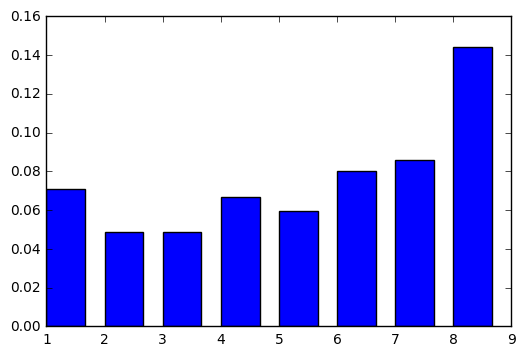

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# http://matplotlib.org/examples/api/barchart_demo.html

# N = len(otfcalc_times.keys())

# fig, ax = plt.subplots()

# ind = np.arange(N)
# width = 0.35

# otfMeans = [sum(otfcalc_times[r]) / float(len(otfcalc_times[r])) for r in sorted(otfcalc_times.keys())]
# otfStd = None
# rects2 = ax.bar(ind, otfMeans, width, color='y')

# ax.set_ylabel('Time (seconds)')
# ax.set_xlabel('r (size of combination)')
# ax.set_title('Query Time By R')
# ax.set_xticks(ind + width)
# ax.set_xticklabels(('1', '2', '3', '4', '5'))

print(otfcalc_times.keys())

otfMeans = [sum(otfcalc_times[r]) / float(len(otfcalc_times[r])) for r in sorted(otfcalc_times.keys())]
print(otfMeans)

N = len(otfcalc_times.keys())
r = range(RMIN, RMAX + 1)
width = 1/1.5
plt.bar(r, otfMeans, width, color="blue")


fig = plt.gcf()



plt.show()